## This repository contains the code for the paper

### Self-supervised Learning with Physics-aware Neural Networks I: Galaxy Model Fitting


#### Semantic autoencoders contain a trainable encoder but replace the trainable decoder by a non-trainable decoder model. The decoder can be analytical (this example) or non-analytical in which case we have to compute and provide the model's gradient during training.

#### This example predicts the three parameters of an exponential model. 

#### In order to go around the problem of generating coordinates to evaluate the model inside the tensorflow graph we supply, in addition to the input images, two auxiliary images with coordinates to be evaluated by the decoder function.



In [1]:
import tensorflow as tf

import time

from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, Concatenate, MaxPooling2D
from keras.layers import Layer
from keras.models import Model

from keras import optimizers
from keras import regularizers

from keras import backend as K
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12345)

import cv2

Using TensorFlow backend.


In [2]:
#--- Use only the memory we need
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
import sys
sys.path.insert(0, '/home/miguel/.local/python_utils/')
import utils_idl as idl
from Imaging.image_grids import show_image_row as show_image_row

In [4]:
def save_image_row(_ims, name=None):    
    import scipy
    
    off = 4
    nx,ny = _ims[0].shape
    print(nx,ny)
        
    imout = np.zeros((ny, nx*4 + off*(4-1))) + np.max(_ims)
    for i, im_i in enumerate(_ims):
        imout[:,i*nx + i*off:(i+1)*nx + i*off] = im_i
    
    if name!=None:
        scipy.misc.imsave(name, scipy.misc.imresize(imout, (ny*4,nx*4*4),interp='nearest') )
        
    return imout

In [5]:
#----------------------------------------------------------
#   Create x and y arrays with coordinates
#----------------------------------------------------------
def make_xy_coords(_n, _range=(0,1)):
    x = np.linspace(_range[0],_range[1], _n)
    y = np.linspace(_range[0],_range[1], _n)
    return np.meshgrid(x, y)

In [6]:
#----------------------------------------------------------
#   Really wasteful way of passing coordinates to the network 
#     but for this simple case it is ok...
#----------------------------------------------------------
def make_coord_list(_n, _img_size, _range=(-1,1)):

    xy = make_xy_coords(_img_size, _range=_range)
    xx = xy[0]
    yy = xy[1]
    
    list_xx = []
    list_yy = []
    for i in range(_n):
        list_xx.append(xx)
        list_yy.append(yy)

    list_xx = np.asarray(list_xx)
    list_yy = np.asarray(list_yy)
    list_xx = np.expand_dims(list_xx, axis=-1)
    list_yy = np.expand_dims(list_yy, axis=-1)
    return list_xx,list_yy

In [7]:
#----------------------------------------------------------
#   Define an exponential profile in numpy. 
#----------------------------------------------------------
def exponential_2d_np(xx,yy, center=[0.0,0.0], amplitude=1.0, scale=0.5, ellipticity=0.0, angle=0.0):

    scl_a = scale
    scl_b = scl_a * (1-ellipticity)
    
    angle = angle*180  # OJO
    theta = angle*np.pi/180 
    #--- Rotate coordinates
    xt = np.cos(theta) * (xx - center[0]) - np.sin(theta)*(yy - center[1])
    yt = np.sin(theta) * (xx - center[0]) + np.cos(theta)*(yy - center[1])
    #--- Radius
    rt = np.sqrt(np.square(xt/scl_a) + np.square(yt/scl_b))
    #return np.power(amplitude * np.exp(-rt),0.75)
    return amplitude * np.exp(-rt)

In [8]:
#----------------------------------------------------------
#   Define an exponential profile in tensorflow. 
#----------------------------------------------------------
def exponential_2d_tf(_params):
    xx    = _params[0]
    yy    = _params[1]
    scale = _params[2]
    ellip = _params[3]
    angle = _params[4]
    
    angle = angle*180  # OJO
    scl_a = scale
    scl_b = scl_a * (1-ellip)

    theta = angle*3.1415926535/180
    #--- Rotate coordinates
    xt = K.cos(theta)*xx - K.sin(theta)*yy
    yt = K.sin(theta)*xx + K.cos(theta)*yy
    #--- Radius
    rt = K.sqrt(K.square(xt/scl_a) + K.square(yt/scl_b))
    #return K.pow(K.exp(-rt),0.75)
    return K.exp(-rt)

In [9]:
def get_activations(_base_model, _layer_name, _inp1, _inp2, _inp3):
    model = Model(inputs=_base_model.input, outputs=_base_model.get_layer(_layer_name).output)
    features = (np.array(model.predict([_inp1,_inp2,_inp3])))
    return features

In [10]:
def my_mse(y_true, y_pred):
    error = y_true-y_pred
    return K.mean(K.pow(K.square(error), 0.25))

In [11]:
#----------------------------------------------------------
#
#   This layer implements an analytic decoder. Note that the coordinates
#     are passed as inputs[0] and inputs[1] an the exponential profile 
#     parameters are passed as inputs[2].
#
#   Passing coordinates as images is not the most elegant way but I wanted to
#     try trick this for other more complex layers that I will use later.
#
#    See including more than one input here: https://github.com/keras-team/keras/issues/2364
#----------------------------------------------------------
class decoderLayer(Layer):

    # initialize the layer, and set an extra parameter axis. No need to include inputs parameter!
    def __init__(self, axis, **kwargs):
        self.axis = axis
        self.result = None
        super(decoderLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(decoderLayer, self).build(input_shape)

    #-----------------------------------------------
    #  Define the decoder here, note how are parameters passed
    #-----------------------------------------------
    def call(self, inputs, **kwargs):
        
        #=== Separate input components
        #--- Independent variable, this is not a true parameter
        _xx    = inputs[0]
        _yy    = inputs[1]
  
        #--- Exponential model parameters
        _p     = inputs[2]
        _scale = _p[:,0]
        _ellip = _p[:,1]
        _angle = _p[:,2]

        #--- Pass this tuple to tensorflow for evaluation
        elems = (_xx, _yy, _scale, _ellip, _angle)
        
        #--- Model for which we want to predict parameters
        parametric_model = tf.map_fn(exponential_2d_tf, elems, dtype=tf.float32, back_prop=True)
  
        return parametric_model

    #-----------------------------------------------
    # Return output shape. In this case the output shape
    # is the same as the distance field i.e first input
    #-----------------------------------------------
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [12]:
#--- Define coordinates as images
coord_xx = Input(shape=(64,64,1))
coord_yy = Input(shape=(64,64,1))

#--- Number of parameters at the bottleneck. These are the parameters to be read in the
#    input[2] of the custom decoder layer
n_params = 3

#--- inp2 is path that produces the model parameters (exponent in this case)
inp = Input(shape=(64,64,1))

#--- Neural network, produces one single parameter per input (image)
x = Conv2D(filters=  32, kernel_size=(3,3), activation='relu', padding='same')(inp)
x = Conv2D(filters=  32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=  64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = Conv2D(filters=  64, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=  128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = Conv2D(filters=  128, kernel_size=(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='sigmoid')(x)
x = Dense(32, activation='sigmoid')(x)
x = Dense( n_params, activation='sigmoid',name='layer_param')(x)

#--- This is our custom layer that simply returns the input image to some given exponent
out = decoderLayer(axis=1)([coord_xx, coord_yy, x])

#--- Define inputs and outputs
model = Model( inputs=[coord_xx, coord_yy, inp], outputs=out )
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

***

In [13]:
#model.compile(optimizer='sgd',loss='mae', metrics=["mae"])
model.compile(optimizer='adadelta',loss='mae', metrics=["mae"])

In [14]:
#--- Number of samples
n_sam = 10000
n_pix = 64

scale_im = 4.0

half_pix = 0#1.0/n_pix/2.0

#--- Coordinates image. We will pass this to the neural net
xx, yy = make_coord_list(n_sam, n_pix)
xx = xx/n_pix*scale_im + half_pix
yy = yy/n_pix*scale_im + half_pix

#--- Intermediate parameters
par_scale = np.random.uniform(0.01,0.05, size=n_sam)
par_ellip = np.random.uniform(0.2,0.75, size=n_sam)
par_angle = np.random.uniform(0,1, size=n_sam)

In [15]:
#--- Generate profiles for training
y_true = np.zeros((n_sam, n_pix, n_pix, 1))
for i in range(n_sam):
    y_true[i,:,:,0] = exponential_2d_np(xx[i,:,:,0],yy[i,:,:,0], scale=par_scale[i], ellipticity=par_ellip[i], angle=par_angle[i])

In [16]:
#--- Add Gaussian noise
noise_sigma = 0.025
y_true_noise = np.zeros((n_sam, n_pix, n_pix, 1))
for i in range(n_sam):
    y_true_noise[i,:,:,0] = y_true[i,:,:,0] + np.random.randn(n_pix, n_pix)*noise_sigma

## Lets see a comparison of a clean image (left) and a noisy one (right)

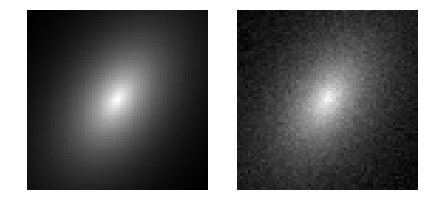

In [17]:
show_image_row([y_true[0,:,:,0],y_true_noise[0,:,:,0]])

## Here flor clarity I removed the training output log...

In [1]:
time_start = time.time()
history = model.fit([xx,yy, y_true_noise], y_true, batch_size=20, epochs=1000, validation_split=0.1)
time_end = time.time()
print('>>> Training time:', time_end - time_start)

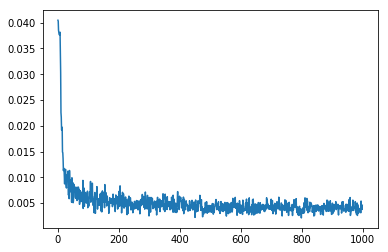

In [20]:
plt.plot(history.history['val_loss'])

loss_history = np.asarray(history.history['loss'])
np.save('loss_history',loss_history)
loss_val_history = np.asarray(history.history['val_loss'])
np.save('loss_val_history',loss_val_history)

***
## Results
***

### Generate new data for testing

In [21]:
n_sam = 1000
n_pix = 64

scale_im = 4.0

half_pix = 0#1.0/n_pix/2.0

#--- Coordinates image. We will pass this to the neural net
xx, yy = make_coord_list(n_sam, n_pix)
xx = xx/n_pix*scale_im + half_pix
yy = yy/n_pix*scale_im + half_pix

#--- Intermediate parameters
par_scale_test = np.random.uniform(0.01,0.05, size=n_sam)
par_ellip_test = np.random.uniform(0.2,0.75, size=n_sam)
par_angle_test = np.random.uniform(0,1, size=n_sam)

#--- Generate profiles for training
y_test = np.zeros((n_sam, n_pix, n_pix, 1))
for i in range(n_sam):
    y_test[i,:,:,0] = exponential_2d_np(xx[i,:,:,0],yy[i,:,:,0], scale=par_scale_test[i], ellipticity=par_ellip_test[i], angle=par_angle_test[i])

In [22]:
#--- Add Gaussian noise
noise_sigma = 0.025
y_test_noise = np.zeros((n_sam, n_pix, n_pix, 1))
for i in range(n_sam):
    y_test_noise[i,:,:,0] = y_test[i,:,:,0] + np.random.randn(n_pix, n_pix)*noise_sigma

In [24]:
#--- Lets evaluate the model.
pred = model.predict([xx,yy, y_test_noise])

### Get the parameters from the bottleneck as activations

In [25]:
acts = get_activations(model, 'layer_param', xx,yy, y_test_noise)

(1000, 3)


### Plot true vs predicted scale

/home/miguel/Develop/anaconda3/envs/keras_tf/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


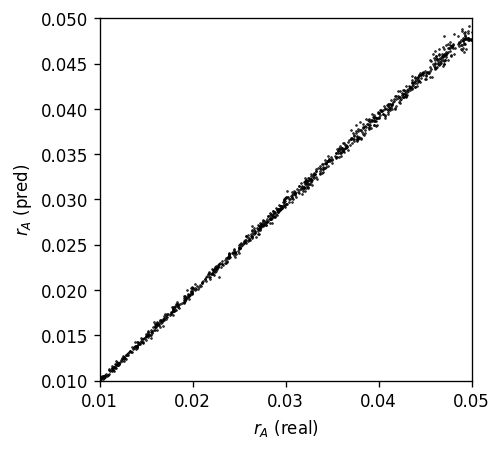

>>> Dispersion scale: 0.0005540738841073844


In [26]:
idl.plot_scatter(par_scale_test, acts[:,0],xrange=[0.01,0.05],yrange=[0.01,0.05],xtitle='$r_A$ (real)', ytitle='$r_A$ (pred)',eps='exponential_fit_scale.eps')

print('>>> Dispersion scale:', np.std(par_scale_test- acts[:,0]))

### Plot true vs predicted ellipticity

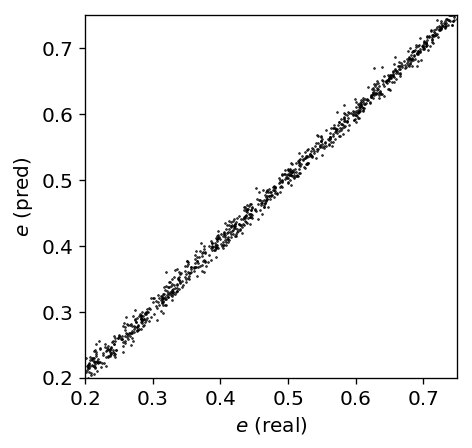

>>> Dispersion ellipticity: 0.009142738138846937


In [35]:
idl.plot_scatter(par_ellip_test, acts[:,1], xtitle='$e$ (real)', ytitle='$e$ (pred)',xrange=[0.2,0.75],yrange=[0.2,0.75],eps='exponential_fit_ellipticity.eps')

print('>>> Dispersion ellipticity:', np.std(par_ellip_test- acts[:,1]))

### Plot true vs predicted position angle. Since the networks fails at the periodic angle boundaries (0-180 degrees) we compute the dispersion from points aways from the boundaries.

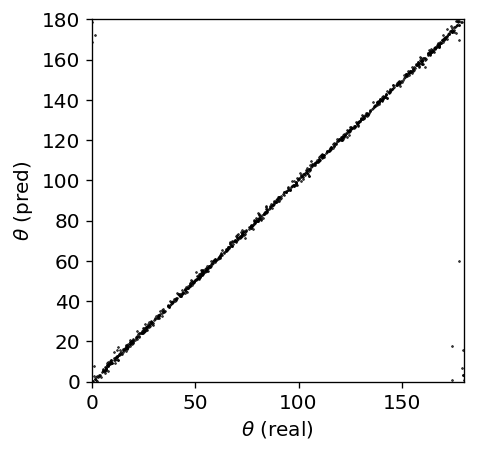

(885,)
>>> Dispersion angle: 0.9236188360664803


In [39]:
idl.plot_scatter(par_angle_test*180, acts[:,2]*180,xrange=[0,180],yrange=[0,180],xtitle='$\\theta$ (real)', ytitle='$\\theta$ (pred)',eps='exponential_fit_theta.eps')

val = ((par_angle_test*180>10) * (par_angle_test*180<170)).nonzero()[0]
print('>>> Dispersion angle:', np.std(par_angle_test[val]*180- acts[val,2]*180))

### Show some examples. From left to right:

- Original image with no noise
- Original image with added noise
- Predicted image
- Residual image (predicted minus original noisy image)

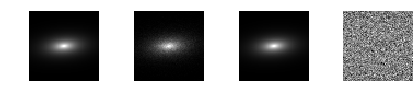

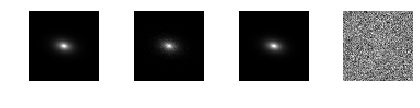

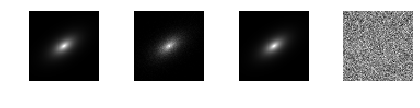

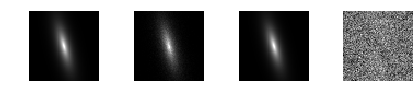

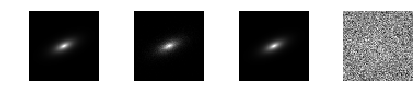

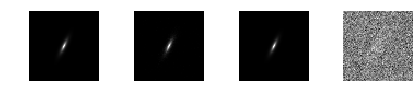

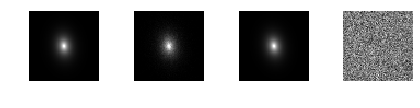

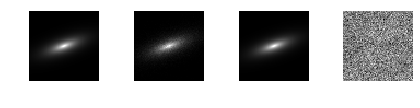

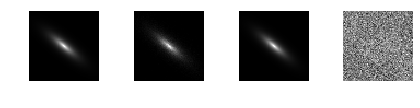

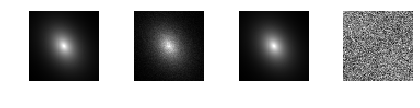

In [29]:
for i in range(0,10):
    show_image_row([np.power(y_test[i,:,:,0],2),np.power(y_test_noise[i,:,:,0],2), np.power(pred[i,:,:,0],2), y_test_noise[i,:,:,0]-pred[i,:,:,0]])